# Example 3 - Train classification models (DL)

In this notebook, we'll train classification models (CNN, RF, PU-learning, Co-training), see how they performs? Also, saved those models for prediction on test set. 

In [1]:
import os
import numpy as np
import pandas as pd
import glob
import pickle
import random
import random
import shutil
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

%matplotlib inline

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Step 1. Transform train & test data

In this step, we'll save npy file (0-255, 4 channels) into image, into train/class_x/ and test/class_x/ folders.  

In [3]:
train_dir = "npy/train"
train_dst = "CNN_model/data/train"
test_dir = "npy/test"
test_dst = "CNN_model/data/test"

In [4]:
files = glob.glob(train_dst + '/AH' + '/*')
for f in files:
    os.remove(f)
files = glob.glob(train_dst + '/NAH' + '/*')
for f in files:
    os.remove(f)
files = glob.glob(test_dst + '/AH' + '/*')
for f in files:
    os.remove(f)
files = glob.glob(test_dst + '/NAH' + '/*')
for f in files:
    os.remove(f)

In [5]:
class_names = ['AH', 'NAH']

In [6]:
max_k = 2087

First, get files for each class in Train folder. 

In [7]:
for c in class_names:
    os.makedirs(os.path.join(train_dst, c), exist_ok=True)
    if c == 'AH':
        class_npy = [i for i in os.listdir(train_dir) if '4.npy' in i]
    else:
        neg_npy = [i for i in os.listdir(train_dir) if ('1.npy' in i) or ('2.npy' in i) or ('3.npy' in i)]
        unlabeled_npy = [i for i in os.listdir(train_dir) if '0.npy' in i]
        class_npy = neg_npy + random.sample(unlabeled_npy, 1 * max_k - len(neg_npy)) # keep 1:1 ratio
    # begin copy
    for item in class_npy:
        item_src = os.path.join(train_dir, item)
        item_dst = os.path.join(train_dst, c, item.split('.')[0] + '.jpg') 
        npy = np.load(item_src)
        npy = npy[:, :, :3] # only first 3 channels
        img = Image.fromarray(npy, 'RGB')
        img.save(item_dst)

Second, get files for each class in Test folder. 

In [8]:
for c in class_names:
    os.makedirs(os.path.join(test_dst, c), exist_ok=True)
    if c == 'AH':
        class_npy = [i for i in os.listdir(test_dir) if '4.npy' in i]
    else:
        class_npy = [i for i in os.listdir(test_dir) if ('1.npy' in i) or ('2.npy' in i) or ('3.npy' in i)]
    # begin copy
    for item in class_npy:
        item_src = os.path.join(test_dir, item)
        item_dst = os.path.join(test_dst, c, item.split('.')[0] + '.jpg')
        npy = np.load(item_src)
        npy = npy[:, :, :3] # only first 3 channels
        img = Image.fromarray(npy, 'RGB')
        img.save(item_dst)

## Step 3. Prepare train & test data loader

Define data loader. 

In [9]:
pretrained_size = 224 # 224 * 224
pretrained_means = [0.485, 0.456, 0.406] # for resnet
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                       transforms.Resize(pretrained_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=pretrained_means, 
                                                            std=pretrained_stds)
                                      ])
test_transforms = transforms.Compose([
                                      transforms.Resize(pretrained_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=pretrained_means, 
                                                           std=pretrained_stds)
                                      ])

In [10]:
train_data = datasets.ImageFolder(root=train_dst, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dst, transform=test_transforms)

In [11]:
len(train_data), len(test_data)

(4174, 558)

Here, we create validation set from training data. 

In [12]:
VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

Then overwrite the validation transforms, making sure to do a deepcopy to stop this also changing the training data transforms.

In [13]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [14]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 3756
Number of validation examples: 418
Number of testing examples: 558


Next, we create the iterators. 

In [15]:
BATCH_SIZE = 32 # 32 or 64 got very similar results!
train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

To ensure the images have been processed correctly we can plot a few of them - ensuring we re-normalize the images so their colors look right. 

In [16]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [17]:
def plot_images(images, labels, classes, normalize=True):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))    
    fig = plt.figure(figsize=(15, 15))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)        
        image = images[i]
        if normalize:
            image = normalize_image(image)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

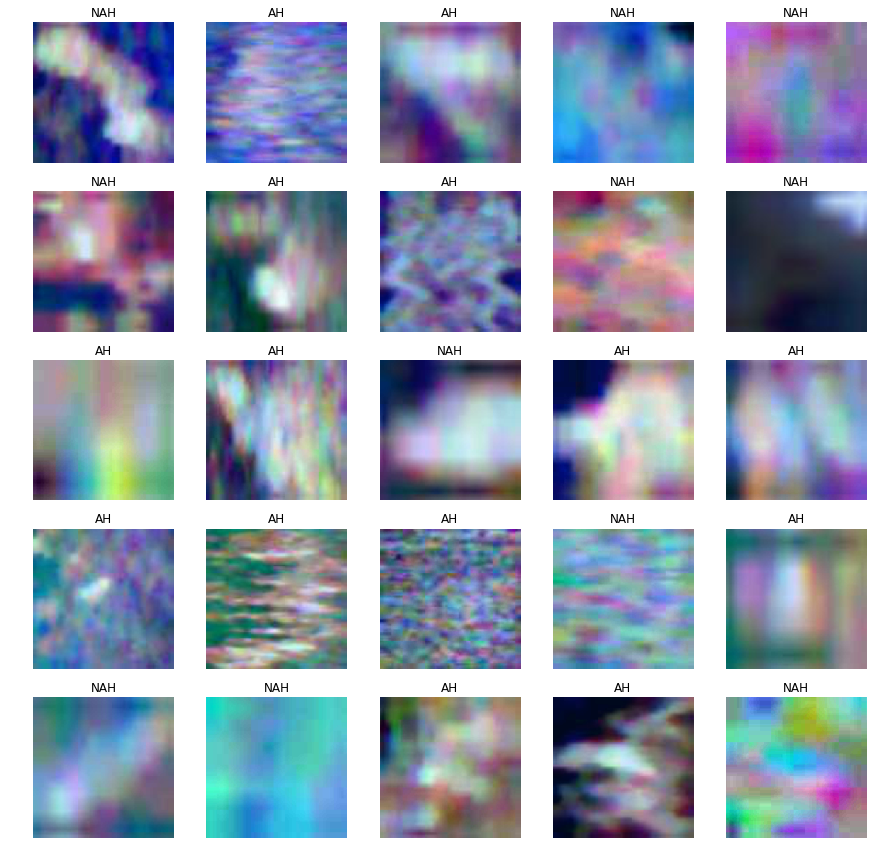

In [18]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes
plot_images(images, labels, classes)

## Step 3. Train classification models (CNN)

In this step, we'll train classification models to differentiate AH and other categories. 

In [19]:
dataloaders = {'train': train_iterator, 'val': valid_iterator}
dataset_sizes = {'train': n_train_examples, 'val': n_valid_examples}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Note, here I met the issue: CUDA error: out of memory, Solution: use a smaller batch_size -> The error, which you has provided is shown, because you ran out of memory on your GPU. A way to solve it is to reduce the batch size until your code will run without this error.

The training step would be 10x faster if using GPU. 

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/home/yazh0781/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6008 Acc: 0.6536
val Loss: 0.5359 Acc: 0.6914

Epoch 1/19
----------
train Loss: 0.5046 Acc: 0.7425
val Loss: 0.5221 Acc: 0.7297

Epoch 2/19
----------
train Loss: 0.4269 Acc: 0.7929
val Loss: 0.5410 Acc: 0.7010

Epoch 3/19
----------
train Loss: 0.3288 Acc: 0.8610
val Loss: 0.5828 Acc: 0.7081

Epoch 4/19
----------
train Loss: 0.2460 Acc: 0.8999
val Loss: 0.6433 Acc: 0.7010

Epoch 5/19
----------
train Loss: 0.1817 Acc: 0.9308
val Loss: 0.7008 Acc: 0.7129

Epoch 6/19
----------
train Loss: 0.1276 Acc: 0.9529
val Loss: 0.7417 Acc: 0.6938

Epoch 7/19
----------
train Loss: 0.0580 Acc: 0.9875
val Loss: 0.6804 Acc: 0.7464

Epoch 8/19
----------
train Loss: 0.0528 Acc: 0.9883
val Loss: 0.6753 Acc: 0.7368

Epoch 9/19
----------
train Loss: 0.0387 Acc: 0.9947
val Loss: 0.6846 Acc: 0.7368

Epoch 10/19
----------
train Loss: 0.0372 Acc: 0.9933
val Loss: 0.6965 Acc: 0.7560

Epoch 11/19
----------
train Loss: 0.0342 Acc: 0.9952
val Loss: 0.6940 Acc: 0.7321

Epoch 12/19
----------
t

## Step 4. Test classification models

In this step, we'll test classification to differentiate AH and other categories. 

In [23]:
def get_predictions(iterator):
    model_ft.eval()
    pred_labels = []
    labels = []
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)            
            outputs = model_ft(x)
            _, y_pred = torch.max(outputs, 1)
            pred_labels.append(y_pred.cpu())
            labels.append(y.cpu())
    pred_labels = torch.cat(pred_labels, dim=0)
    labels = torch.cat(labels, dim = 0)
    return labels, pred_labels

In [24]:
labels, pred_labels = get_predictions(test_iterator)
print(torch.sum(labels == 0).float()) # 0: AH
# print(pred_labels)

tensor(453.)


In [25]:
corrects = torch.eq(labels, pred_labels)

In [26]:
target_true = torch.sum(labels == 0).float()
predicted_true = torch.sum(pred_labels == 0).float()
correct_true = torch.sum((pred_labels == labels) * (pred_labels == 0)).float()

In [27]:
recall = correct_true / target_true
precision = correct_true / predicted_true
f1_score = 2 * precision * recall / (precision + recall)
print(recall, precision, f1_score)

tensor(0.7660) tensor(0.9378) tensor(0.8433)
